In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from joblib import dump,load


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, SCORERS, confusion_matrix, classification_report,  precision_score, recall_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, precision_recall_curve, RocCurveDisplay, roc_curve, auc, accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV, ElasticNet, LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC

In [23]:
df = pd.read_csv("../DATA/wine_fraud.csv")

In [25]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red


In [27]:
df['quality'].unique()

array(['Legit', 'Fraud'], dtype=object)

/var/folders/sl/4slwjbhd1rz6q3665v1k847c0000gn/T/ipykernel_91979/2405982027.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df,x='quality',palette='magma')


<Axes: xlabel='quality', ylabel='count'>

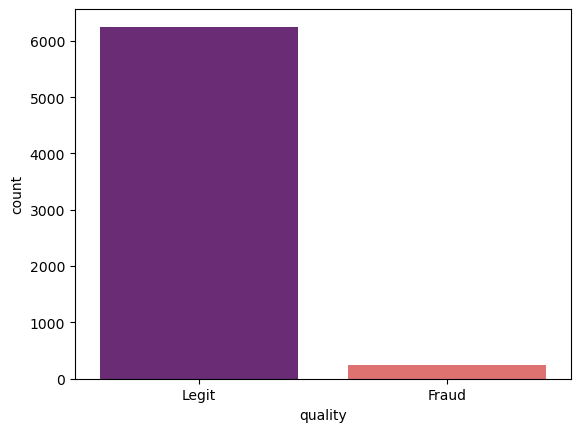

In [29]:
sns.countplot(df,x='quality',palette='magma')

<Axes: xlabel='type', ylabel='count'>

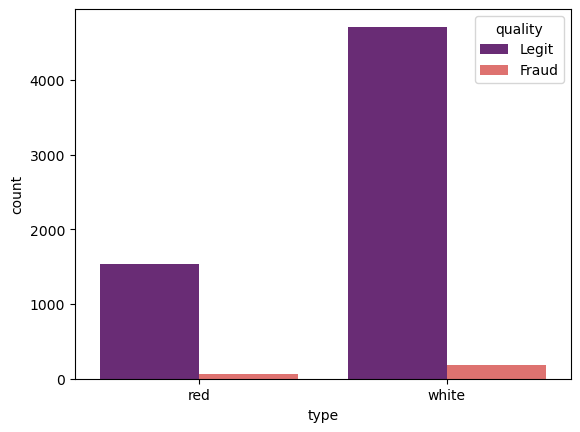

In [31]:
sns.countplot(df,x='type',palette='magma',hue='quality')

In [33]:
t = df.groupby(['type','quality'])['fixed acidity'].count().reset_index()

t['frac'] = t['fixed acidity'] / t.groupby('type')['fixed acidity'].transform('sum') * 100

t

,type,quality,fixed acidity,frac
0,red,Fraud,63,3.939962
1,red,Legit,1536,96.060038
2,white,Fraud,183,3.736219
3,white,Legit,4715,96.263781


In [35]:
df['fraud'] = df['quality'].apply(lambda x: 0 if x=='Legit' else 1)
df.corr(numeric_only=True)['fraud']

fixed acidity           0.021794
volatile acidity        0.151228
citric acid            -0.061789
residual sugar         -0.048756
chlorides               0.034499
free sulfur dioxide    -0.085204
total sulfur dioxide   -0.035252
density                 0.016351
pH                      0.020107
sulphates              -0.034046
alcohol                -0.051141
fraud                   1.000000
Name: fraud, dtype: float64

<Axes: xlabel='fraud'>

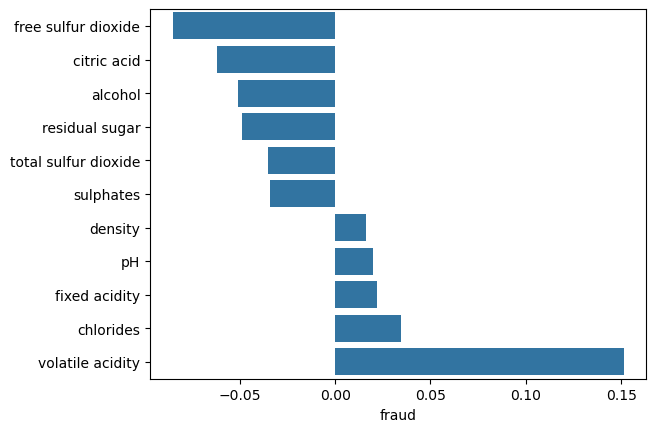

In [63]:
sns.barplot(df.corr(numeric_only=True)[:-1]['fraud'].sort_values(),orient='h')

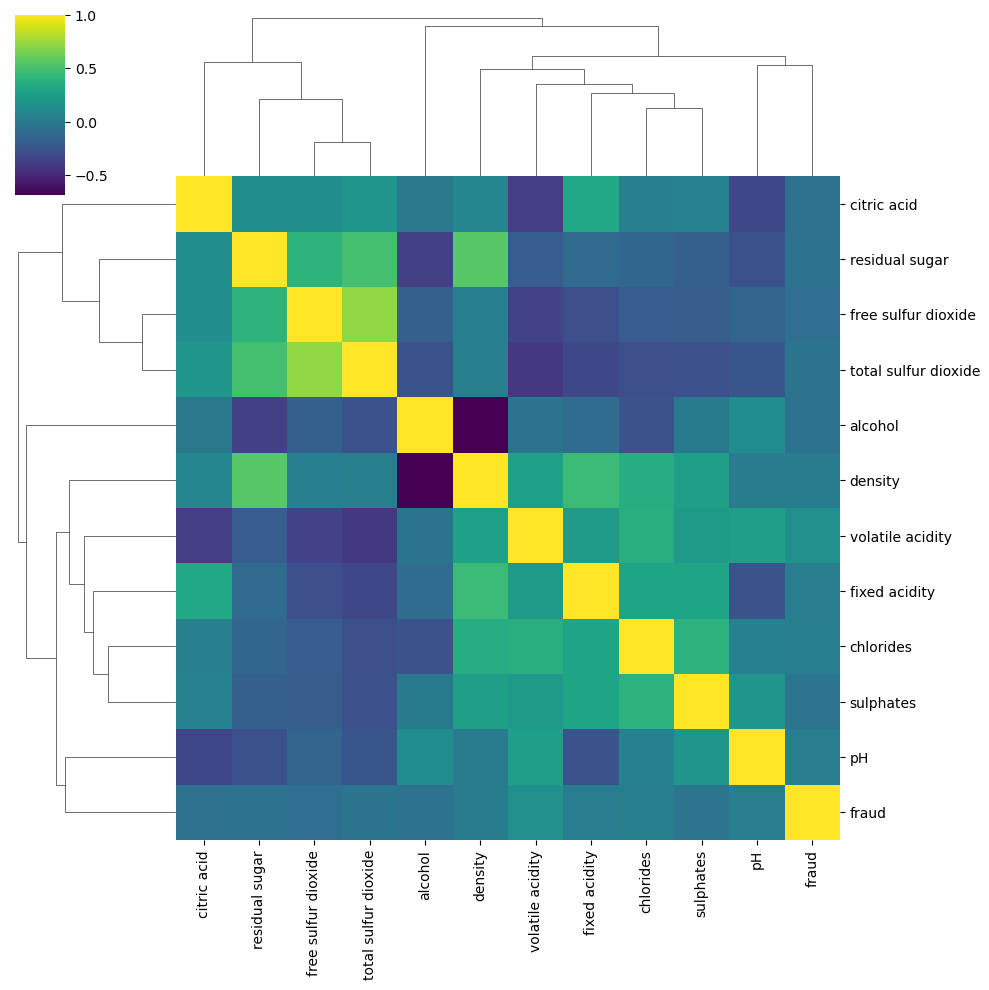

In [68]:
sns.clustermap(df.corr(numeric_only=True),cmap='viridis')

In [78]:
df['type'] = pd.get_dummies(df['type'],drop_first=True)
df = df.drop('fraud',axis=1)

df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,Legit,False
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,Legit,False
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,Legit,False
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,Legit,False
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,Legit,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,Legit,True
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,Legit,True
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,Legit,True
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,Legit,True


In [81]:
y = df['quality']
X = df.drop('quality',axis=1)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

svc = SVC(class_weight='balanced')

param_grid = {'C':[0.001,0.01,0.1,0.5,1],'gamma':['scale','auto']}
grid = GridSearchCV(svc,param_grid)

#grid.fit(scaled_X_train,y_train)

In [118]:
grid.fit(scaled_X_train,y_train)

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1],
                         'gamma': ['scale', 'auto']})

In [123]:
grid.best_params_

{'C': 1, 'gamma': 'auto'}

In [126]:
grid_pred = grid.predict(scaled_X_test)

In [129]:
confusion_matrix(y_test,grid_pred)

array([[ 17,  10],
       [ 92, 531]])

In [132]:
print(classification_report(y_test,grid_pred))

              precision    recall  f1-score   support

       Fraud       0.16      0.63      0.25        27
       Legit       0.98      0.85      0.91       623

    accuracy                           0.84       650
   macro avg       0.57      0.74      0.58       650
weighted avg       0.95      0.84      0.88       650

